In [3]:
import pysftp
import os 
import numpy as np
import pandas as pd
import netCDF4
import numpy as np

from scipy import io
from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard
from dotenv import load_dotenv   #for python-dotenv method
from datetime import datetime

pd.options.mode.chained_assignment = None  # default='warn'


In [30]:
# Get Temperature Data]
def generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/PROCESSED_ERA5_ONLINE/COMPRESSED/WIND_EASTWARD/',
                    geo_filtering = {'min_lat':60,'max_lat':80,'min_lon':-180, 'max_lon': 180},
                    year_selection = '1995',
                    data_name = 'wind_eastward'):
    
    grid = map_grid(grid_size=None, source = 'era5')
    wizard = data_wizard()
    res_mean = []
    res_mean_selection = []
    file_names = []
    files = os.listdir(path)
    files.sort()
    for file in files:
        if file[:4] == year_selection:
            print(file)
            temperature = np.load(path + file)['arr_0']
            # temperature = np.loadtxt(path + file, delimiter=",")

            select_area_indexer = grid.select_area_indexer(
                min_lat= geo_filtering['min_lat'],
                max_lat= geo_filtering['max_lat'],
                min_lon= geo_filtering['min_lon'],
                max_lon= geo_filtering['max_lat'])

            data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = temperature)

            file_names.append(file[:10])
            res_mean.append(np.nanmean(temperature))
            res_mean_selection.append(np.nanmean(data))

    df = pd.DataFrame(data={
        'dates' : file_names,
        f'{data_name}_mean' : res_mean,
        f'{data_name}_mean_selection' : res_mean_selection
    })
    
    df['dates'] = pd.to_datetime(df['dates'])
    df = df.sort_values(by='dates')
    df = df.reset_index()
    df = df.drop(columns=['index'])

    return df

def find_ssw(df):
    values = df['wind_eastward_mean_cos'].to_list()
    SSW_ = [False]

    for i in range(1,len(values)):
        if values[i-1] >= 0 and values[i] < 0:
            SSW_.append(True)
        else:
            SSW_.append(False)

    df['SSW_'] = SSW_
    df['SSW_flag'] = False

    day_threshold = 1
    for index in df[df['SSW_'] == True].index:
        if len(df.iloc[index:index+day_threshold].loc[df['wind_eastward_mean_cos'] < -0.5]) >= day_threshold :
            df['SSW_flag'].iloc[index] = True
    return df
    

In [41]:

df_all  = pd.DataFrame()
for year in range(1986,1986+1):

    YEAR = year
    print(YEAR)

    # # FROM Corwins SFTP
    # df_wind = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_sftp/level_115/WIND_EASTWARD/',
    #                     geo_filtering = {'min_lat':55,'max_lat':65,'min_lon':-180, 'max_lon': 180},
    #                     year_selection = f'{YEAR}',
    #                     data_name = 'wind_eastward')

    # df_temperature = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_sftp/level_115/TEMPERATURE/',
    #                     geo_filtering = {'min_lat':60,'max_lat':80,'min_lon':-180, 'max_lon': 180},
    #                     year_selection = f'{YEAR}',
    #                     data_name = 'temperature')

    # FROM ONLINE
    df_wind = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/',
                        geo_filtering = {'min_lat':59,'max_lat':61,'min_lon':-180, 'max_lon': 180},
                        year_selection = f'{YEAR}',
                        data_name = 'wind_eastward')

    df_temperature = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/TEMPERATURE/',
                        geo_filtering = {'min_lat':60,'max_lat':90,'min_lon':-180, 'max_lon': 180},
                        year_selection = f'{YEAR}',
                        data_name = 'temperature')

    df = pd.merge(df_wind,df_temperature[['dates','temperature_mean_selection']],how='left', on='dates')
    
    df['wind_eastward_mean_cos'] = df['wind_eastward_mean'] * np.cos(np.deg2rad(60))
    df['temperate_mean_cos'] = df['temperature_mean_selection'] * np.cos(np.deg2rad(60))
    df['temperature_pct_change'] = 100 * df['temperature_mean_selection'].pct_change()

    df = find_ssw(df)
    # find the index of the row where col2 is equal to 7
    index = df.index[df['SSW_flag'] == True].tolist()


    df_all = pd.concat([df_all,df])


# # save all
# df = df_all
# df = df.reset_index()
# df = df.drop(columns = ['index'])
# index = df.index[df['SSW_flag'] == True].tolist()

# SAVE_SSW_EVENT = True
# if SAVE_SSW_EVENT:
#     if len(index) > 0:
#         for index in index:
#             day_window = 30
#             df_dataset = df.loc[index-day_window:index+day_window-20]
#             date_str = df.loc[index]['dates'].strftime("%Y-%m-%d")
#             df_dataset.to_csv(f'ssw_events_saved/{date_str}_ssw.csv', sep=',',index=False)

df['temperature_pct_change'] = df['temperature_mean_selection'].pct_change()

1986
1986-01-01.npz
1986-01-02.npz
1986-01-03.npz
1986-01-04.npz
1986-01-05.npz
1986-01-06.npz
1986-01-07.npz
1986-01-08.npz
1986-01-09.npz
1986-01-10.npz
1986-01-11.npz
1986-01-12.npz
1986-01-13.npz
1986-01-14.npz
1986-01-15.npz
1986-01-16.npz
1986-01-17.npz
1986-01-18.npz
1986-01-19.npz
1986-01-20.npz
1986-01-21.npz
1986-01-22.npz
1986-01-23.npz
1986-01-24.npz
1986-01-25.npz
1986-01-26.npz
1986-01-27.npz
1986-01-28.npz
1986-01-29.npz
1986-01-30.npz
1986-01-31.npz
1986-02-01.npz
1986-02-02.npz
1986-02-03.npz
1986-02-04.npz
1986-02-05.npz
1986-02-06.npz
1986-02-07.npz
1986-02-08.npz
1986-02-09.npz
1986-02-10.npz
1986-02-11.npz
1986-02-12.npz
1986-02-13.npz
1986-02-14.npz
1986-02-15.npz
1986-02-16.npz
1986-02-17.npz
1986-02-18.npz
1986-02-19.npz
1986-02-20.npz
1986-02-21.npz
1986-02-22.npz
1986-02-23.npz
1986-02-24.npz
1986-02-25.npz
1986-02-26.npz
1986-02-27.npz
1986-02-28.npz
1986-03-01.npz
1986-03-02.npz
1986-03-03.npz
1986-03-04.npz
1986-03-05.npz
1986-03-06.npz
1986-03-07.npz
1986-

In [42]:
import plotly.graph_objects as go

# df = df_dataset
# Create figure and plot the DataFrame
fig = go.Figure()

# fig.add_trace(go.Scatter(x=df['dates'], y=df['res_filtered'].rolling(3).mean(), name='Res Filtered', mode='markers', marker=dict(color='blue', size=2)))
fig.add_trace(go.Scatter(x=df['dates'], y=df['wind_eastward_mean_cos'], name='wind_eastward_mean_selection', line=dict(color='blue')))
# fig.add_trace(go.Scatter(x=df['dates'], y=df['temperature_mean_selection'], name='Temperature Selection Mean', mode='markers', marker=dict(color='orange', size=3), yaxis='y2'))
fig.add_trace(go.Scatter(x=df['dates'], y=df['temperature_mean_selection'], name='Temperature Selection Mean', line=dict(color='orange'), yaxis='y2'))

# fig.add_trace(go.Scatter(x=df['dates'], y=df['temperature_pct_change'], name='temperature_pct_change', line=dict(color='green'), yaxis='y3'))

# Add a dashed line at y=0
fig.add_shape(type='line', x0=df['dates'].min(), y0=0, x1=df['dates'].max(), y1=0, line=dict(color='gray', dash='dash'))

# Find the index of the first negative value
first_negative_index = (df['wind_eastward_mean_cos'] < 0).idxmin()

# Add vertical lines for SSW_flag == True
for i, row in df.iterrows():
    if row.SSW_flag == True:
        fig.add_shape(type='line', x0=row.dates, y0=-50, x1=row.dates, y1=50, line=dict(color='red', dash='dash'))

# Set layout
fig.update_layout(
    yaxis=dict(
        range=[-50, 80],
        title='wind_eastward_mean_cos'
    )
    ,yaxis2=dict(
        range=[190, 250],
        title='Temperature Selection Mean',
        side='right',
        overlaying='y'
    )
    # ,yaxis3=dict(
    #     range=[-30, 30],
    #     title='Temperature % change',
    #     side='right',
    #     overlaying='y'
    # )
    ,xaxis=dict(title='Dates'),
    title=f'ZMZW at 60◦ N latitude in {YEAR}',
    legend=dict(orientation="h", y=1.2, x=0.5)
)

# Show the plot
fig.show()

In [43]:
df

,dates,wind_eastward_mean,wind_eastward_mean_selection,temperature_mean_selection,wind_eastward_mean_cos,temperate_mean_cos,temperature_pct_change,SSW_,SSW_flag
0,1986-01-01,22.606564,43.145556,205.508976,11.303282,102.754488,NaN,False,False
1,1986-01-02,22.717718,52.034717,206.531135,11.358859,103.265567,0.004974,False,False
2,1986-01-03,22.067909,57.650667,209.914490,11.033954,104.957245,0.016382,False,False
3,1986-01-04,22.194294,68.103476,209.032319,11.097147,104.516160,-0.004203,False,False
4,1986-01-05,22.487466,68.837749,209.525214,11.243733,104.762607,0.002358,False,False
...,...,...,...,...,...,...,...,...,...
146,1986-12-27,23.743501,28.760854,208.101979,11.871750,104.050989,0.028069,False,False
147,1986-12-28,21.678194,43.905552,215.725262,10.839097,107.862631,0.036632,False,False
148,1986-12-29,23.415302,54.705836,209.253771,11.707651,104.626885,-0.029999,False,False
149,1986-12-30,24.042851,50.407652,208.243268,12.021425,104.121634,-0.004829,False,False


/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_49894/1252707302.py:35: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



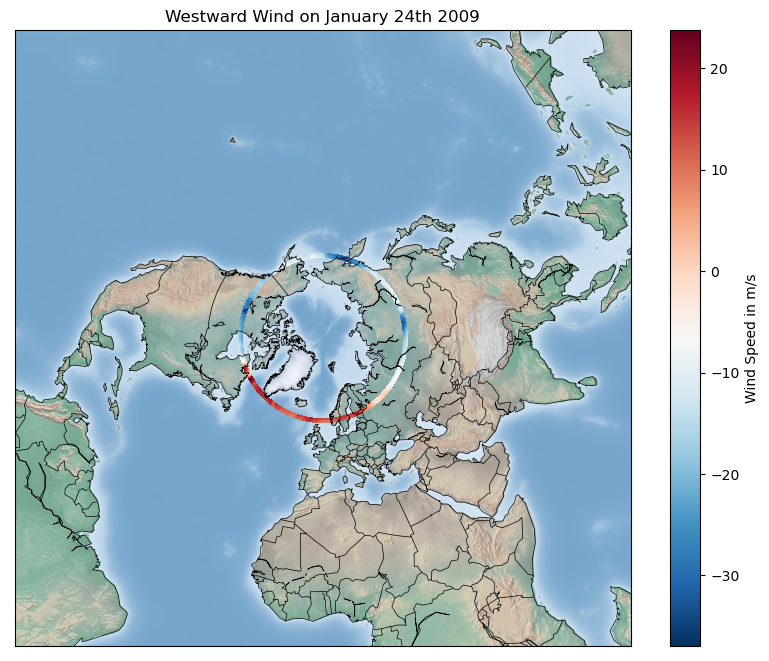

In [44]:
path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/'
file = '2009-01-25.npz'
geo_filtering = {'min_lat':59,'max_lat':61,'min_lon':-360, 'max_lon': 360}
grid = map_grid(grid_size=None, source = 'era5_online')
wizard = data_wizard()

data = np.load(path + file)['arr_0']

select_area_indexer = grid.select_area_indexer(
    min_lat= geo_filtering['min_lat'],
    max_lat= geo_filtering['max_lat'],
    min_lon= geo_filtering['min_lon'],
    max_lon= geo_filtering['max_lat'])

data_filtered = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = data)


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10, 8))

# use to plot areas in any section of the globe using a stereographic projection
# m = Basemap(projection='stere', resolution='c',
#             width=8E6, height=8E6, 
#             lat_0=55, lat_1=65,
#             lon_0=0,lon_1 = 360)

# use to plot north pole stero plot
m = Basemap(projection='npstere',boundinglat=0,lon_0=0,resolution='c')
m.shadedrelief(scale=0.5)

m.pcolormesh(grid.grid_[0], 
             grid.grid_[1], 
             data_filtered,
             latlon=True, cmap='RdBu_r',
             shading='auto')

m.drawcoastlines(linewidth=0.5,linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid',color='k')

plt.title('Westward Wind on January 24th 2009')
plt.colorbar(label='Wind Speed in m/s')